# Noise variance experiment

In [1]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    files.sort()
    if max_num_batches is not None:
        files = files[:max_num_batches]
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    trajectory = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectory
    }


model_to_name = {
    'mel_sto': 'DSB Log Mel',
    'stft_sto': 'DSB STFT',
    'stft_det': 'DSB STFT',
    'gfb': 'GFB STFT',
    'baseline': 'Baseline',
}

model_to_color = {
    'mel_sto': '#4E79A7',
    'stft_sto': '#F28E2B',
    'stft_det': '#F28E2B',
    'gfb': '#E15759',
}

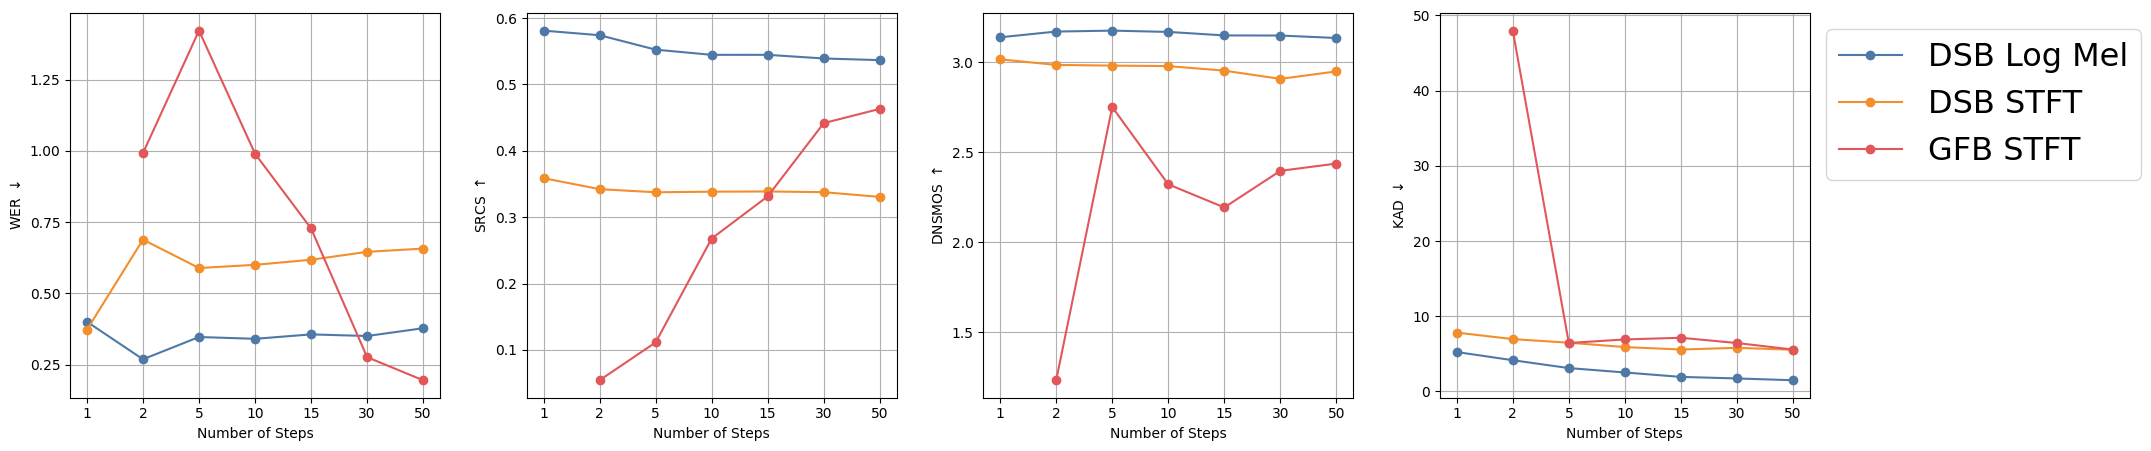

In [2]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "clip"

num_steps = [1, 2, 5, 10, 15, 30, 50]  # reversed order for plotting
for model in ['mel_sto', 'stft_sto', 'gfb', 'baseline']:
    data[model] = dict()
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        metric_dict = dict()
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            
            if model == 'baseline':
                path = f"test_results/test_{what_test}/baseline"
            else:
                path = f"test_results/test_{what_test}/{model}_{num_step}"
                
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_dict[num_step] = value
            
            if model == 'baseline':
                continue

        data[model][metric] = metric_dict

fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 23})

for i, (model, metrics) in enumerate(data.items()):    
    if model == 'baseline':
        continue
    
    xvalues = range(len(num_steps)) if model != 'gfb' else range(1, len(num_steps))  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['wer'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[1].plot(xvalues, metrics['srcs'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[2].plot(xvalues, metrics['dnsmos'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[3].plot(xvalues, metrics['kad'].values(), marker='o', linestyle='-', color=model_to_color[model], label=model_to_name[model])
for i in range(4):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_ylabel([r"WER $\downarrow$", r"SRCS $\uparrow$", r"DNSMOS $\uparrow$", r"KAD $\downarrow$"][i])
    axs[i].grid(True)
    axs[i].set_xticks(range(len(num_steps)))
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/test_{what_test}/metrics.png", bbox_inches='tight', dpi=300)
plt.show()


In [3]:
# make it easy to copy paste the results to txt file
n_decimals = 2
for m in ['stft_sto', 'mel_sto', 'gfb', 'baseline']:
    if m == 'baseline':
        num_steps = [1]
    if m in ['stft_sto', 'mel_sto']:
        num_steps = [30, 1]
    if m == 'gfb':
        num_steps = [30, 2]
    
    for num_step in num_steps:
        if m == 'baseline':
            print(f"{model_to_name[m]} & {data[m]['dnsmos'][num_step]:.{n_decimals}f} & {data[m]['wer'][num_step]:.{n_decimals}f} & {data[m]['srcs'][num_step]:.{n_decimals}f} & {data[m]['kad'][num_step]:.{n_decimals}f} \\\\")
        else:
            print(f"{model_to_name[m]} ({num_step} step) & {data[m]['dnsmos'][num_step]:.{n_decimals}f} & {data[m]['wer'][num_step]:.{n_decimals}f} & {data[m]['srcs'][num_step]:.{n_decimals}f} & {data[m]['kad'][num_step]:.{n_decimals}f} \\\\")


DSB STFT (30 step) & 2.91 & 0.65 & 0.34 & 5.80 \\
DSB STFT (1 step) & 3.02 & 0.37 & 0.36 & 7.82 \\
DSB Log Mel (30 step) & 3.15 & 0.35 & 0.54 & 1.73 \\
DSB Log Mel (1 step) & 3.14 & 0.40 & 0.58 & 5.24 \\
GFB STFT (30 step) & 2.40 & 0.28 & 0.44 & 6.44 \\
GFB STFT (2 step) & 1.23 & 0.99 & 0.05 & 47.99 \\
Baseline & 2.68 & 0.15 & 0.47 & 15.18 \\


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


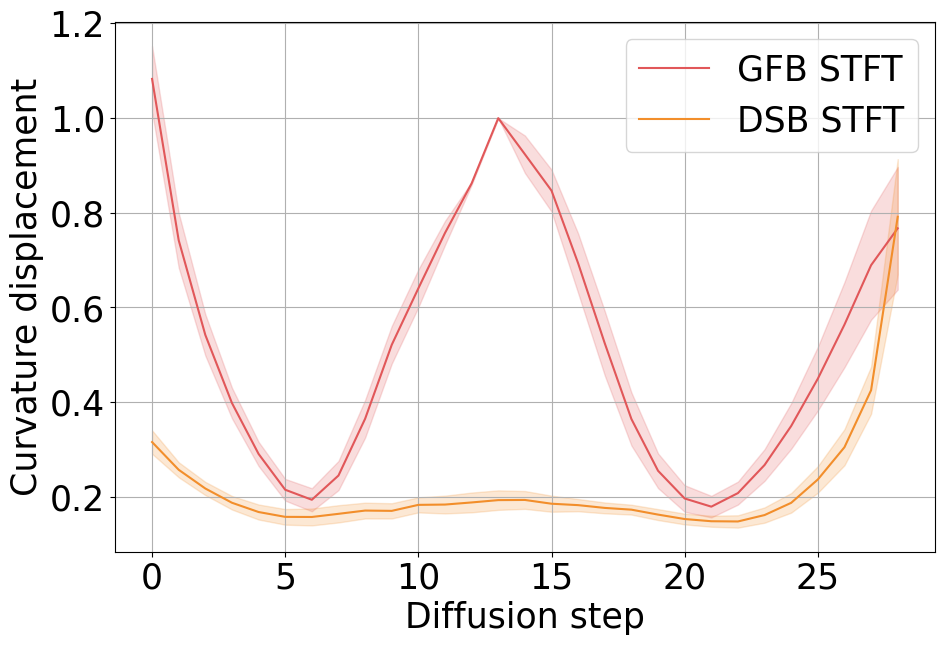

In [5]:
# investigate trajectory curvature

import torch
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature(trajectories : Tensor, timeschedule : Tensor) -> Tensor:
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    n_steps = trajectories.shape[0]
    
    forward = trajectories[:n_steps // 2]
    backward = trajectories[-(n_steps // 2):]
        
    forward_Ct = calculate_curvature_displacement(forward, timeschedule)
    backward_Ct = calculate_curvature_displacement(backward, timeschedule) # ideally, timeschedule should be reversed but it is symmetric
    backward_Ct = backward_Ct.flip(dims=[0])  # reverse the backward curvature
    
    C_ts = torch.cat([forward_Ct, backward_Ct], dim=1)
    return C_ts

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    return calculate_gfb_curvature(trajectories, timeschedule)

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    return calculate_curvature_displacement(trajectories, timeschedule)

models = ['gfb', 'stft_det']
num_steps = 30
data = dict()
n_batches = 1

for model in models:
    data[model] = dict()

    path = f"test_results/test_clip/{model}_{num_steps}"
    
    if model == 'gfb':
        cts = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches)
    else:
        cts = calculate_dsb_curvature_from_path(path, max_num_batches=n_batches)

    data[model] = cts
        
gfb_mean = data['gfb'].mean(dim = 0)[1:]
gfb_std = data['gfb'].std(dim = 0)[1:]

stft_mean = data['stft_det'].mean(dim = 0)[1:]
stft_std = data['stft_det'].std(dim = 0)[1:]

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(gfb_mean, label=model_to_name['gfb'], color=model_to_color['gfb'])
plt.fill_between(range(len(gfb_mean)), gfb_mean - gfb_std, gfb_mean + gfb_std, alpha=0.2, color=model_to_color['gfb'])

plt.plot(stft_mean, label=model_to_name['stft_det'], color=model_to_color['stft_det'],)
plt.fill_between(range(len(stft_mean)), stft_mean - stft_std, stft_mean + stft_std, alpha=0.2, color=model_to_color['stft_det'])

plt.xlabel("Diffusion step")
plt.ylabel("Curvature displacement")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test_results/test_clip/curvature_{num_steps}.png", bbox_inches='tight', dpi=300)
plt.show()

In [7]:
import os
import torchaudio

path = "/work3/s214630/Latent-DSB/audio_samples/"
os.makedirs(path, exist_ok=True)
n_samples = 5

for experiment in ['clip', 'rir']:
    for model in ['baseline', 'mel_sto', 'stft_sto', 'gfb']:
        if model == 'baseline':
            samples_path = f"test_results/test_{experiment}/baseline"
            batches = load_all_batches(samples_path, max_num_batches=3)
            x0 = batches['x0']
            x1 = batches['x1']
            for i in range(n_samples):
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_{i}.wav"), x0[i].squeeze().unsqueeze(0), 16000)
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x1_{i}.wav"), x1[i].squeeze().unsqueeze(0), 16000)
            
        else:
            if model == 'gfb':
                num_steps = [30]
            else:
                num_steps = [30, 1]
            
            for num_step in num_steps:
                samples_path = f"test_results/test_{experiment}/{model}_{num_step}"
                batches = load_all_batches(samples_path, max_num_batches=1)
                x0_recon = batches['x0_recon']
                for i in range(n_samples):
                    torchaudio.save(os.path.join(path, f"{experiment}_{model}_{num_step}_x0_recon_{i}.wav"), x0_recon[i].squeeze().unsqueeze(0), 16000)
            